In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas_datareader import data
yf.pdr_override()
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from torchvision import transforms


class PriceToImgae:
    def __init__(self, days, width, height, price_area_height, volume_area_height, pixelwidth, pixelheight):
        self.days = days
        self.width = width
        self.height = height
        self.price_area_height = price_area_height
        self.volume_area_height = volume_area_height
        self.pixelwidth = pixelwidth
        self.pixelheight = pixelheight
        self.price_area_logical_height = int(self.price_area_height / self.pixelheight)
        self.volume_area_logical_height = int(self.volume_area_height / self.pixelheight)

    def __drawPixel(self, x, y, pixel):
        logical_height = int(self.height / self.pixelheight)
        for i in range(self.pixelwidth):
            for j in range(self.pixelheight):
                self.img.putpixel((self.pixelwidth * x + i, self.pixelheight * (logical_height - 1 - y) + j), pixel)

    def __drawPrice(self, index, price, moving_average, volume, pixel):
        open_price = price[0]
        high_price = price[1]
        low_price = price[2]
        close_price = price[3]

        #  draw open price
        self.__drawPixel(3 * index, self.volume_area_logical_height + 1 + open_price, pixel)  
        # draw the stick from high price to low price
        for i in range(high_price - low_price + 1):
            self.__drawPixel(3 * index + 1, self.volume_area_logical_height + 1 + low_price + i, pixel)
        # draw close price
        self.__drawPixel(3 * index + 2, self.volume_area_logical_height + 1 + close_price, pixel)
        # draw volume bar
        for i in range(volume):
            self.__drawPixel(3 * index + 1, i, pixel)

    def getImg(self, price_array, moving_average_array, volume_array, background_pixel, color_pixel):
        self.img = Image.new("RGB", (self.width, self.height), background_pixel)
        for i in range(price_array.shape[0]):
            self.__drawPrice(i, price_array[i], moving_average_array[i], volume_array[i], color_pixel)
            
            # draw MA line
            self.__drawPixel(3 * i + 1, self.volume_area_logical_height + 1 + moving_average_array[i], color_pixel)
            if i!=(price_array.shape[0]-1):
                diff = moving_average_array[i+1]-moving_average_array[i]
                if diff >= 0:
                  self.__drawPixel(3 * i + 2, self.volume_area_logical_height + 1 + moving_average_array[i]+(diff//2), color_pixel)
                  self.__drawPixel(3 * i + 3, self.volume_area_logical_height + 1 + moving_average_array[i]+diff-(diff//2), color_pixel)
                else:
                  self.__drawPixel(3 * i + 2, self.volume_area_logical_height + 1 + moving_average_array[i]-((-diff)//2), color_pixel)
                  self.__drawPixel(3 * i + 3, self.volume_area_logical_height + 1 + moving_average_array[i+1]+((-diff)//2), color_pixel)
                
        return self.img

def get_image_with_price(price): # price: [open, high, low, close, MA, volume]
    
    # size of one pixel
    PIXEL_WIDTH = 1
    PIXEL_HEIGHT = 1
    # width of the graph
    WIDTH = 3 * price.shape[0] * PIXEL_WIDTH
    
    days = price.shape[0]
    if days == 20:
      # 51 pixels for OHLC, 1 pixel empty, 12 pixels for volume
        PRICE_LOGICAL_HEIGHT = 51
        VOLUME_LOGICAL_HEIGHT = 12
    elif days == 5:
        PRICE_LOGICAL_HEIGHT = 25
        VOLUME_LOGICAL_HEIGHT = 6  
    PRICE_AREA_HEIGHT = PRICE_LOGICAL_HEIGHT * PIXEL_HEIGHT
    V0LUME_AREA_HEIGHT = VOLUME_LOGICAL_HEIGHT * PIXEL_HEIGHT

    # height of the graph
    HEIGHT = PRICE_AREA_HEIGHT + V0LUME_AREA_HEIGHT + PIXEL_HEIGHT

    # scale all prices and volumes 
    sclr1 = MinMaxScaler((1, PRICE_LOGICAL_HEIGHT))
    sclr2 = MinMaxScaler((1, VOLUME_LOGICAL_HEIGHT))
    price_minmax = sclr1.fit_transform(price[:, :-1].reshape(-1, 1)).reshape(price.shape[0], -1).astype(int)
    volume_minmax = sclr2.fit_transform(price[:, -1].reshape(-1, 1)).reshape(price.shape[0]).astype(int)


    # transform the price and volume data to a white and black graph
    p2i = PriceToImgae(days, WIDTH, HEIGHT, PRICE_AREA_HEIGHT, V0LUME_AREA_HEIGHT, PIXEL_WIDTH, PIXEL_HEIGHT)
    background_pixel = (0, 0, 0, 100)
    color_pixel = (255, 255, 255, 100)
    image = p2i.getImg(price_minmax[:, :-1], price_minmax[:, -1], volume_minmax, background_pixel, color_pixel)
    # convert the RGB graph to a grey graph
    image = image.convert('L')
    return image

In [3]:
class MyDataset(Dataset):
    
  def __init__(self, img, label):
    self.img = torch.Tensor(img)
    self.label = torch.Tensor(label)
    self.len = len(img)
  
  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.img[idx], self.label[idx]

In [4]:
SP500_list = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP',
       'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE',
       'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN',
       'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK',
       'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA',
       'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO',
       'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX',
       'BDX', 'WRB', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK',
       'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO',
       'BF-B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH',
       'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE',
       'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG',
       'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX',
       'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP',
       'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST',
       'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA',
       'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISH',
       'DIS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DD',
       'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV',
       'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX',
       'EQR', 'ESS', 'EL', 'ETSY', 'RE', 'EVRG', 'ES', 'EXC', 'EXPE',
       'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FAST', 'FRT', 'FDX', 'FITB',
       'FRC', 'FSLR', 'FE', 'FIS', 'FISV', 'FLT', 'FMC', 'F', 'FTNT',
       'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEHC', 'GEN',
       'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS',
       'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE',
       'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUM',
       'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR',
       'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ',
       'INVH', 'IQV', 'IRM', 'JBHT', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM',
       'JNPR', 'K', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC',
       'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN',
       'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB',
       'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA',
       'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD',
       'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP',
       'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ',
       'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI',
       'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR',
       'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OGN',
       'OTIS', 'PCAR', 'PKG', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR',
       'PEP', 'PKI', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC',
       'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG',
       'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF',
       'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL',
       'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE',
       'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SEDG', 'SO',
       'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS',
       'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY',
       'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT',
       'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UDR', 'ULTA',
       'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VRSN',
       'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WAB',
       'WBA', 'WMT', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST',
       'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL',
       'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
HSI_list = ['0001.HK', '0002.HK', '0003.HK', '0005.HK', '0006.HK', '0011.HK', '0012.HK', '0016.HK', '0017.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0288.HK', '0291.HK', '0316.HK', '0322.HK', '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK', '0992.HK', '1038.HK', '1044.HK', '1088.HK', '1093.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK', '1929.HK', '1997.HK', '2007.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '3690.HK', '3692.HK', '3968.HK', '3988.HK', '6098.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9988.HK', '9999.HK']


In [5]:
# list of Heng Seng Index component stocks and hyper parameters
stock_list = HSI_list
index_ticker = '^HSI'
#index_ticker = '^GSPC'
day = 20
startdate = '2012-01-01'
enddate = '2022-12-31'
train_val_ratio = 0.7
#device = 'cpu'
device = 'cuda'
batchsize = 128
early_stopping_epoch = 2
learningrate = 1e-5
epochs = 150

In [8]:

# prepare the data set
train_x, train_y, test_x, test_y = [], [], [], []
count  = 0
for i in stock_list:
    # fetch data through yahoo finance 
    stockdata = data.get_data_yahoo(tickers=i, start=startdate, end=enddate)
    print(count,': Stock of',i,'has',len(stockdata),'records.')
    count += 1
    if len(stockdata)<day*5:
        continue
    df = pd.DataFrame(columns = ['Open','High','Low','Close','MA','Volume'])
    df['Open']=stockdata["Open"]
    df['High']=stockdata['High']
    df['Low'] =stockdata['Low']
    df['Close']=stockdata['Close']
    df['Volume']=stockdata['Volume']
    # compute moving average
    for i in range(len(df)):
        if i >= day-1:
            df['MA'].iloc[i] = sum(stockdata['Close'].iloc[i-day+1:i+1])/day
    df = df.dropna(axis=0, how='any')
    data_array = np.array(df)
    
    data_list = []
    label_list = []
    # draw the graph of every 5/20 days
    for i in range(len(data_array)):
        if i <= len(data_array)-2*day:
            pixel = get_image_with_price(data_array[i:i+day])
            pixel =np.array(pixel)
            #print(len(pixel))
            data_list.append(pixel)
            if data_array[i+day-1][3]<data_array[i+2*day-1][3]:
                # label [1,0] represents that stock price rises in 20 days
                label_list.append([1,0])
            else:
                # label [0,1] represents that stock price drops in 20 days
                label_list.append([0,1])
                
    # split data set to train set and test(validation) set
    split_idx = int(len(label_list) * train_val_ratio)
    train_x += data_list[:split_idx]
    train_y += label_list[:split_idx]
    test_x += data_list[split_idx:]
    test_y += label_list[split_idx:]

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
# save the data sets
np.save('train_x_20D_HSI',train_x)
np.save('train_y_20D_HSI',train_y)
np.save('test_x_20D_HSI',test_x)
np.save('test_y_20D_HSI',test_y)


[*********************100%***********************]  1 of 1 completed
0 : Stock of 0001.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
1 : Stock of 0002.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
2 : Stock of 0003.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
3 : Stock of 0005.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
4 : Stock of 0006.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
5 : Stock of 0011.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
6 : Stock of 0012.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
7 : Stock of 0016.HK has 2712 records.
[*********************100%***********************]  1 of 1 completed
8 : Stock of 0017.HK has 2712 records.
[*********************100%**

In [10]:
# load the saved data set
train_x = np.load('train_x_20D_HSI.npy',allow_pickle=True)
train_y = np.load('train_y_20D_HSI.npy',allow_pickle=True)
test_x = np.load('test_x_20D_HSI.npy',allow_pickle=True)
test_y = np.load('test_y_20D_HSI.npy',allow_pickle=True)
print('The length of train set:',len(train_x))
print('The length of test set:',len(test_y))

train_dataset = MyDataset(train_x, train_y)
val_dataset = MyDataset(test_x, test_y)

The length of train set: 120182
The length of test set: 51586


In [10]:
positive = 0
negative = 0
for i in train_y:

    if i[0] == 1:
        positive += 1
    if i[0] == 0:
        negative += 1
print('Train set has',positive,'positive labels and',negative,'negative labels.')
positive = 0
negative = 0
for i in test_y:
    if i[0] == 1:
        positive += 1
    if i[0] == 0:
        negative += 1
print('Test set has',positive,'positive labels and',negative,'negative labels.')

Train set has 63230 positive labels and 56952 negative labels.
Test set has 24791 positive labels and 26795 negative labels.


In [8]:
im = Image.fromarray(train_x[-1])
print('Image size:',im.size)
im = im.resize((300,320),resample=0)
im.show()
print('The pixels of the image above are:')
print(train_x[-10])
print('\n')
im = Image.fromarray(train_x[20])
im = im.resize((300,320),resample=0)
im.show()
pic = train_x[0]
print('The pixels of the image above are:')
print(pic)

Image size: (60, 64)
The pixels of the image above are:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ... 255 255   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0 255   0 ...   0 255   0]
 [  0 255   0 ...   0 255   0]]


The pixels of the image above are:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 255   0 ...   0 255   0]
 [  0 255   0 ...   0 255   0]
 [  0 255   0 ...   0 255   0]]


In [7]:
class Net_20D_V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(7,1)),
            nn.LayerNorm([64, 24, 60]),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), padding=(2,1)),
            nn.LayerNorm([128, 12, 60]),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), padding=(2,1)),
            nn.LayerNorm([256, 6, 60]),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        #self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        #x = self.softmax(x)
        return x

In [58]:
class Net_20D_V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.LayerNorm([64, 27, 60]),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.LayerNorm([128, 10, 60]),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.LayerNorm([256, 7, 60]),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)
        #self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [8]:
def init_weights(m):
    # initialize the weights of a model
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [8]:

# load the train set
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, pin_memory=True)
# load the test(validation) set
val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False, pin_memory=True)
# create the model and initialize the weights
net = Net_20D_V2().to(device)
#net = CNN_20D().to(device)
net.apply(init_weights)

NameError: name 'train_dataset' is not defined

In [9]:
def train_loop(dataloader, net, loss_fn, optimizer):
    
    running_loss = 0.0
    current = 0
    acc = 0
    net.train()
    pos = 0
    neg = 0
    pos_hit = 0
    neg_hit = 0
    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y)

            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
            hit = 0
            for i in range(len(y_pred)):
                if y[i][0]==1:
                    pos += 1
                    if y_pred[i][0]>y_pred[i][1] :
                        hit += 1
                        pos_hit += 1
                if y[i][1]==1:
                    neg += 1
                    if y_pred[i][0]<=y_pred[i][1] :
                    
                        hit += 1
                        neg_hit += 1
            acc = (acc*current + hit)/(current+len(X)) 
            
            
            current += len(X)
            t.set_postfix({'running_loss':running_loss})
    
    return running_loss,acc,pos_hit/pos, neg_hit/neg

In [10]:
def val_loop(dataloader, net, loss_fn):

    running_loss = 0.0
    current = 0
    acc = 0
    net.eval()
    pos = 0
    neg = 0
    pos_hit = 0
    neg_hit = 0
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                loss = loss_fn(y_pred, y)
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                hit = 0

                for i in range(len(y_pred)):
                    if y[i][0]==1:
                        pos += 1
                        if y_pred[i][0]>y_pred[i][1] :
                            hit += 1
                            pos_hit += 1
                    if y[i][1]==1:
                        neg += 1
                        if y_pred[i][0]<=y_pred[i][1] :
                            hit += 1
                            neg_hit += 1
                acc = (acc*current + hit)/(current+len(X))      
                current += len(X)
            
    return running_loss, acc, pos_hit/pos, neg_hit/neg

In [ ]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningrate)
#optimizer = torch.optim.SGD(net.parameters(), lr=learningrate)
start_epoch = 0
min_val_loss = 1e9
last_min_ind = -1


from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

NameError: name 'net' is not defined

In [19]:
for t in range(start_epoch, epochs):
    print(f"Epoch {t}\n-------------------------------")
    start_time = datetime.datetime.now()
    train_loss, train_acc,train_pos,train_neg = train_loop(train_dataloader, net, loss_fn, optimizer)
    val_loss, val_acc,val_pos,val_neg = val_loop(val_dataloader, net, loss_fn)
    tb.add_histogram("train_loss", train_loss, t)
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
        para_dict = net.state_dict()
    elif t - last_min_ind >= early_stopping_epoch:
        break
    end_time = datetime.datetime.now()
    print('time cost:',end_time-start_time)
    print('val_loss:',val_loss,'val_acc:',val_acc,val_pos,val_neg)
    print('train_loss',train_loss,'train_acc:',train_acc,train_pos,train_neg)

print('Done!')
print('Best epoch: {}, val_loss: {}'.format(last_min_ind+1, min_val_loss))


torch.save(para_dict, "./Net_20D_V2_HSI_1.pkl")


  0%|          | 0/939 [00:00<?, ?it/s]

Epoch 0
-------------------------------


  0%|          | 3/939 [00:00<00:45, 20.67it/s, running_loss=0.845]

time cost: 0:00:55.233631
val_loss: 0.7028411697991034 val_acc: 0.5084131353467988 0.3377435359606309 0.6663183429744355
train_loss 0.9107485330608116 train_acc: 0.5051671631359101 0.5446307132690179 0.4613534204242169
Epoch 1
-------------------------------


  0%|          | 3/939 [00:00<00:45, 20.61it/s, running_loss=0.76]

time cost: 0:00:53.750501
val_loss: 0.7001150135191067 val_acc: 0.5001163106269148 0.60477592674761 0.403284194812465
train_loss 0.7739176408163875 train_acc: 0.5082874307300596 0.5595761505614424 0.45134499227419583
Epoch 2
-------------------------------


  0%|          | 2/939 [00:00<00:48, 19.24it/s, running_loss=0.736]

time cost: 0:00:55.525475
val_loss: 0.6966217224213305 val_acc: 0.5130267902143996 0.26223226170787783 0.7450643776824034
train_loss 0.7409909212238727 train_acc: 0.5150854537285119 0.5771152933733987 0.44621786767804467
Epoch 3
-------------------------------


  0%|          | 3/939 [00:00<00:45, 20.55it/s, running_loss=0.728]

time cost: 0:00:55.924446
val_loss: 0.6981330815686361 val_acc: 0.4977319427751716 0.6497922633213666 0.3570442246687815
train_loss 0.7281380987598237 train_acc: 0.5143948345010073 0.5861141863039696 0.43476963056609075
Epoch 4
-------------------------------


  0%|          | 3/939 [00:00<00:45, 20.56it/s, running_loss=0.697]

time cost: 0:00:54.962909
val_loss: 0.694610811271678 val_acc: 0.5126972434381423 0.33028115041749023 0.68147042358649
train_loss 0.7192748985503034 train_acc: 0.5183554941671813 0.5960303653329115 0.43211827503862904
Epoch 5
-------------------------------


  0%|          | 2/939 [00:00<00:47, 19.64it/s, running_loss=0.733]

time cost: 0:00:55.284004
val_loss: 0.6941201056634697 val_acc: 0.5149459155584849 0.26804082126578194 0.7433849598805747
train_loss 0.7119911262767296 train_acc: 0.5211429332179536 0.6036849596710422 0.42950203680292176
Epoch 6
-------------------------------


  0%|          | 3/939 [00:00<00:45, 20.66it/s, running_loss=0.703]

time cost: 0:00:55.472352
val_loss: 0.6984938639287074 val_acc: 0.4911991625634862 0.7328869347747167 0.2675872364247061
train_loss 0.7073378240646957 train_acc: 0.5223910402556127 0.6110706942906848 0.42393594605983986
Epoch 7
-------------------------------


100%|██████████| 404/404 [00:09<00:00, 43.88it/s]


Done!
Best epoch: 6, val_loss: 0.6941201056634697


In [59]:
# load the saved model 
#torch.save(para_dict, "./Net_20D_V1_SP_1.pkl")
new_net = Net_20D_V2().to(device)
#new_net.apply(init_weights)                          
new_net.load_state_dict(torch.load("./Net_20D_V2_HSI_1.pkl"))        
new_net.eval()
loss_fn = nn.CrossEntropyLoss()

In [14]:
testdata = data.get_data_yahoo(tickers=stock_list[0], start=startdate, end=enddate)
testdata
# select the dates for test
testtime = []

for i in range(len(testdata)):
  if i>=2*day-1 and i<=len(testdata)-day-1:
    if (i+1)%day==0:
      testtime.append(testdata.index[i])
# the dataframe to save prediction probabilities
pred_prob = pd.DataFrame(data=None, columns=stock_list, index=testtime)
testtime = []
for i in range(len(testdata)):
  if i>=2*day-1:
    if (i+1)%day==0:
      testtime.append(testdata.index[i])
# the dataframe to save true stock prices
true_price = pd.DataFrame(data=None, columns=stock_list, index=testtime)


[*********************100%***********************]  1 of 1 completed


In [15]:
true_price

,0001.HK,0002.HK,0003.HK,0005.HK,0006.HK,0011.HK,0012.HK,0016.HK,0017.HK,0027.HK,...,3968.HK,3988.HK,6098.HK,6690.HK,6862.HK,9618.HK,9633.HK,9888.HK,9988.HK,9999.HK
2012-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pred_prob

,0001.HK,0002.HK,0003.HK,0005.HK,0006.HK,0011.HK,0012.HK,0016.HK,0017.HK,0027.HK,...,3968.HK,3988.HK,6098.HK,6690.HK,6862.HK,9618.HK,9633.HK,9888.HK,9988.HK,9999.HK
2012-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
test_pred = []
test_true = []
test_loss = 0
count = 0
for i in stock_list:
  teststock = data.get_data_yahoo(tickers=i, start=startdate, end=enddate)
  testdf = pd.DataFrame(columns = ['Open','High','Low','Close','MA','Volume'])
  testdf['Open']=teststock["Open"]
  testdf['High']=teststock['High']
  testdf['Low'] =teststock['Low']
  testdf['Close']=teststock['Close']
  testdf['Volume']=teststock['Volume']
  for j in range(len(testdf)):
      if j >= day-1:
          testdf['MA'].iloc[j] = sum(teststock['Close'].iloc[j-day+1:j+1])/day
  testdf = testdf.dropna(axis=0, how='any')
 
  testdata_list = []
  testlabel_list = []
  dataindex_list = []
  for dataindex in true_price.index.to_list():
    if dataindex in testdf.index.to_list():
      true_price[i][dataindex] = testdf['Close'][dataindex]
  for dataindex in pred_prob.index.to_list():

    if dataindex in testdf.index.to_list():
      row_index = testdf.index.to_list().index(dataindex)
      if row_index+day<len(testdf) and row_index>=(day-1):
        pixel = get_image_with_price(np.array(testdf.iloc[row_index-day+1:row_index+1]))
        pixel = np.array(pixel)
        testdata_list.append(pixel)
        
        if testdf['Close'].iloc[row_index]<testdf['Close'].iloc[row_index+day]:
                # label [1,0] represents that stock price rises in 20 days
          testlabel_list.append([1,0])
        else:
                # label [0,1] represents that stock price drops in 20 days
          testlabel_list.append([0,1])
        
        dataindex_list.append(dataindex)

  testdata_list = np.array(testdata_list)
  testlabel_list = np.array(testlabel_list)
  
  test_dataset = MyDataset(testdata_list, testlabel_list)
 
  test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False)
  n = 0

  with torch.no_grad():
    with tqdm(test_dataloader) as t:
              for batch, (X, y) in enumerate(t):
                  X = X.to(device)
                  y = y.to(device)
                  #print(batch,X)
                  y_pred = new_net(X)
                  #print(y_pred)
                  test_pred.append(y_pred)
                  test_true.append(y)
                  test_loss += loss_fn(y_pred,y)*len(y)
                  #print(n,y_pred)
                  pred = torch.nn.functional.softmax(y_pred)
                  #print(pred)
                  pred_prob[i][dataindex_list[n]]=np.float(pred[0][0])
                  n += 1
  print(count,':',i)
  count += 1

print('test loss :',test_loss/len(test_true))
      


[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:11<00:00, 11.09it/s]


0 : 0001.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 644.94it/s]


1 : 0002.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 728.78it/s]


2 : 0003.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 730.30it/s]


3 : 0005.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 596.08it/s]


4 : 0006.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 709.56it/s]


5 : 0011.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 676.63it/s]


6 : 0012.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 699.35it/s]


7 : 0016.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 606.35it/s]


8 : 0017.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 706.64it/s]


9 : 0027.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 607.97it/s]


10 : 0066.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 610.83it/s]


11 : 0101.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 613.85it/s]


12 : 0175.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 608.13it/s]


13 : 0241.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 617.61it/s]


14 : 0267.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 101/101 [00:00<00:00, 691.58it/s]


15 : 0288.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 633.67it/s]


16 : 0291.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 696.87it/s]


17 : 0316.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 714.41it/s]


18 : 0322.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 621.92it/s]


19 : 0386.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 721.80it/s]


20 : 0388.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 726.38it/s]


21 : 0669.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 725.89it/s]


22 : 0688.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 609.60it/s]


23 : 0700.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 723.61it/s]


24 : 0762.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 580.96it/s]


25 : 0823.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 731.36it/s]


26 : 0857.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 732.24it/s]


27 : 0868.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 732.16it/s]


28 : 0881.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 625.72it/s]


29 : 0883.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 718.11it/s]


30 : 0939.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 724.67it/s]


31 : 0941.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 736.21it/s]


32 : 0960.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 109/109 [00:00<00:00, 698.33it/s]


33 : 0968.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 647.80it/s]


34 : 0981.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 732.36it/s]


35 : 0992.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 721.30it/s]


36 : 1038.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 653.54it/s]


37 : 1044.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 663.27it/s]


38 : 1088.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 626.81it/s]


39 : 1093.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 648.91it/s]


40 : 1109.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 91/91 [00:00<00:00, 582.48it/s]


41 : 1113.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 625.00it/s]


42 : 1177.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 22/22 [00:00<00:00, 608.36it/s]


43 : 1209.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 626.94it/s]


44 : 1211.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 681.16it/s]


45 : 1299.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 597.80it/s]


46 : 1378.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 707.83it/s]


47 : 1398.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 52/52 [00:00<00:00, 693.26it/s]


48 : 1810.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 37/37 [00:00<00:00, 663.25it/s]


49 : 1876.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 619.30it/s]


50 : 1928.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 704.59it/s]


51 : 1929.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 60/60 [00:00<00:00, 625.48it/s]


52 : 1997.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 651.72it/s]


53 : 2007.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 711.18it/s]


54 : 2020.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 66/66 [00:00<00:00, 689.20it/s]


55 : 2269.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 692.89it/s]


56 : 2313.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 702.41it/s]


57 : 2318.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 631.82it/s]


58 : 2319.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 732.48it/s]


59 : 2331.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 686.29it/s]


60 : 2382.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 629.40it/s]


61 : 2388.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 613.21it/s]


62 : 2628.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 690.64it/s]


63 : 2688.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 50/50 [00:00<00:00, 618.14it/s]


64 : 3690.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 41/41 [00:00<00:00, 587.59it/s]


65 : 3692.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 704.35it/s]


66 : 3968.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 133/133 [00:00<00:00, 584.12it/s]


67 : 3988.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 53/53 [00:00<00:00, 642.00it/s]


68 : 6098.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 22/22 [00:00<00:00, 561.45it/s]

69 : 6690.HK


[*********************100%***********************]  1 of 1 completed


100%|██████████| 50/50 [00:00<00:00, 601.44it/s]


70 : 6862.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 28/28 [00:00<00:00, 566.27it/s]

71 : 9618.HK


[*********************100%***********************]  1 of 1 completed


100%|██████████| 26/26 [00:00<00:00, 592.86it/s]


72 : 9633.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 19/19 [00:00<00:00, 576.91it/s]

73 : 9888.HK
[*********************100%***********************]  1 of 1 completed

100%|██████████| 35/35 [00:00<00:00, 593.76it/s]


74 : 9988.HK
[*********************100%***********************]  1 of 1 completed


100%|██████████| 29/29 [00:00<00:00, 661.20it/s]

75 : 9999.HK
test loss : tensor(0.6866, device='cuda:0')


In [19]:
true_price.to_csv('true_price_20D_V2_HSI_1.csv')
pred_prob.to_csv('pred_prob_20D_V2_HSI_1.csv')

In [46]:
true_price = pd.read_csv('true_price_20D_V2_HSI_1.csv')
pred_prob = pd.read_csv('pred_prob_20D_V2_HSI_1.csv')

pred_prob['Date'] = pd.to_datetime(pred_prob['Date'])
pred_prob.set_index('Date', inplace=True)
true_price['Date'] = pd.to_datetime(true_price['Date'])
true_price.set_index('Date', inplace=True)

In [47]:
pred_prob

,0001.HK,0002.HK,0003.HK,0005.HK,0006.HK,0011.HK,0012.HK,0016.HK,0017.HK,0027.HK,...,3968.HK,3988.HK,6098.HK,6690.HK,6862.HK,9618.HK,9633.HK,9888.HK,9988.HK,9999.HK
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,0.528763,0.430878,0.472995,0.531185,0.476136,0.508925,0.548752,0.499936,0.529112,0.548802,...,0.497993,0.466946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,0.453759,0.550988,0.496098,0.512517,0.503235,0.485956,0.444243,0.520408,0.483326,0.493488,...,0.494157,0.558591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-03,0.565774,0.532072,0.503462,0.508446,0.516091,0.569454,0.483511,0.467131,0.521617,0.456074,...,0.487065,0.438364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,0.539825,0.484041,0.522614,0.558542,0.609009,0.500182,0.549838,0.541065,0.533338,0.526601,...,0.572802,0.497834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-28,0.583978,0.515611,0.554610,0.590145,0.575517,0.519853,0.541947,0.547636,0.554500,0.548596,...,0.458222,0.517672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-21,0.524726,0.427545,0.496396,0.476987,0.522834,0.500706,0.532324,0.544108,0.490856,0.552218,...,0.562678,0.578940,0.543572,0.540045,0.477307,0.561556,0.497651,0.492517,0.526483,0.550632
2022-08-18,0.469832,0.528989,0.517806,0.506226,0.525702,0.538071,0.562199,0.512877,0.586575,0.473847,...,0.487866,0.539582,0.479815,0.476451,0.525203,0.467768,0.562480,0.518633,0.497427,0.502269
2022-09-16,0.518520,0.518662,0.560628,0.569060,0.632214,0.497453,0.544518,0.576928,0.511480,0.550422,...,0.559995,0.546592,0.504163,0.578260,0.496898,0.523917,0.554423,0.557755,0.560483,0.463415


In [58]:
true_price = true_price.fillna(method="ffill")
long = int(0.2 * len(stock_list))
short = int(0.1* len(stock_list))
print( 'long:',long)
print('short:',short)
ret = 1
ret_list = [1]
tradecost = 3/1000
Index = data.get_data_yahoo(tickers=index_ticker, start=startdate, end=enddate)
Index_list = [1]
Index_ret = 1

for i in range(len(pred_prob.index.to_list())):
  
  a = pred_prob.iloc[i]
  a = a.dropna(how='any')
  a = a.sort_values(ascending=False)
  long_list = a.index.to_list()[:long]
  short_list = a.index.to_list()[len(a)-short:]
  current_ret = 0
  for index in long_list:
    current_ret += ret/(long+short)*(true_price[index].iloc[i+1]/true_price[index].iloc[i]-tradecost)

  for index in short_list:
    current_ret += ret/(long+short)*(true_price[index].iloc[i]/true_price[index].iloc[i+1]-tradecost)

  Index_ret = Index_ret*Index['Close'][true_price.index.to_list()[i+1]]/Index['Close'][true_price.index.to_list()[i]]
  Index_list.append(Index_ret)
  ret = current_ret
  ret_list.append(ret)

long: 15
short: 7
[*********************100%***********************]  1 of 1 completed


In [35]:
def sharpe_ratio(ret, period, RFrate=0.035 ):
    tmp = [ret[i+1]/ret[i]-1 for i in range(len(ret)-1)]
    #print(tmp)
    tmp = [x*252/period-RFrate for x in tmp]
    #print(tmp)
    return np.mean(tmp)/np.std(tmp)
    
def info_ratio(ret, base, period):
    r = [ret[i+1]/ret[i]-1 for i in range(len(ret)-1)]
    b = [base[i+1]/base[i]-1 for i in range(len(base)-1)]
    tmp = [(r[i]-b[i])*252/period for i in range(len(r))]
    return np.mean(tmp)/np.std(tmp)

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

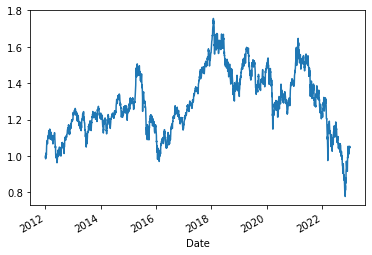

In [36]:
indexdata = data.get_data_yahoo(tickers=index_ticker, start=startdate, end=enddate)
indexdata['Close']=indexdata['Close']/indexdata['Close'].iloc[0]
indexdata['Close'].plot()

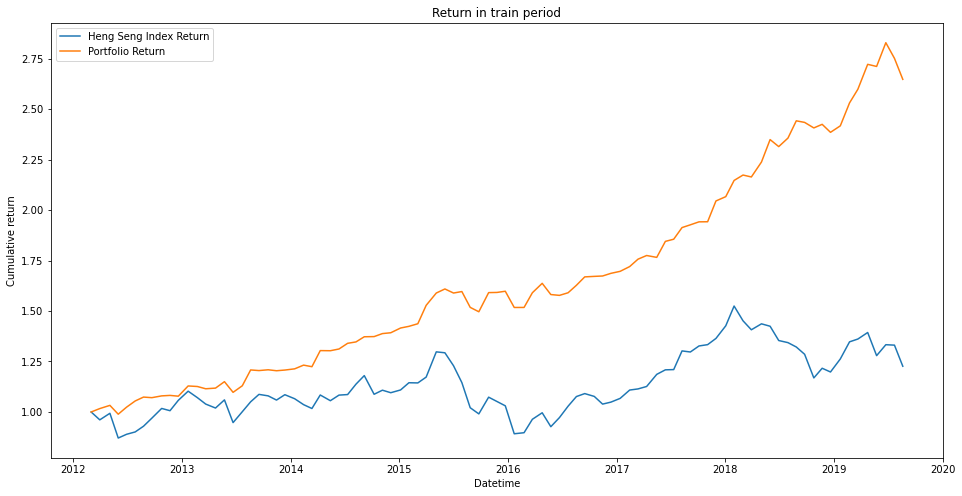

Test set startdate: 2012-03-01 00:00:00
Test set enddate: 2019-08-20 00:00:00
Annualized return: 0.354166078448186
The sharpe ratio: 0.33214841239865917
The information ratio: 0.21756797826839702


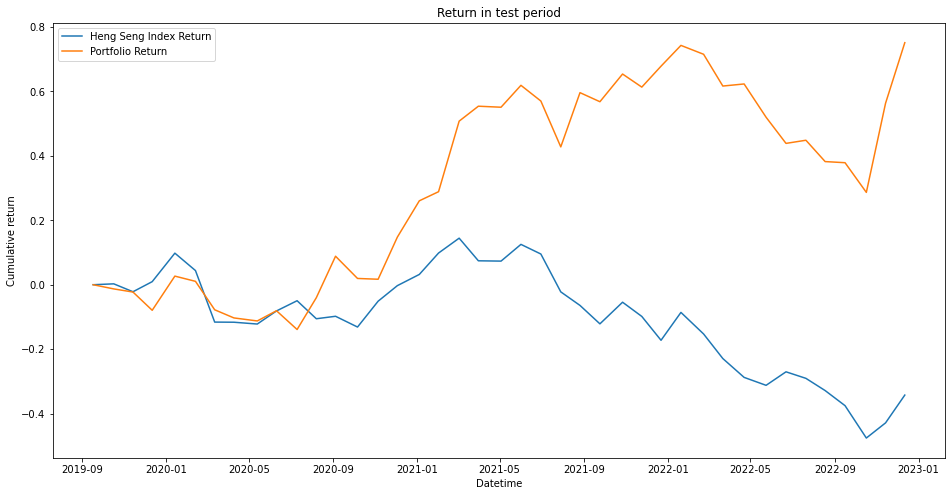

Test set startdate: 2019-09-17 00:00:00
Test set enddate: 2022-11-14 00:00:00
Annualized return: 0.4066775377492372
The sharpe ratio: 0.1257922856303812
The information ratio: 0.2951929561146631


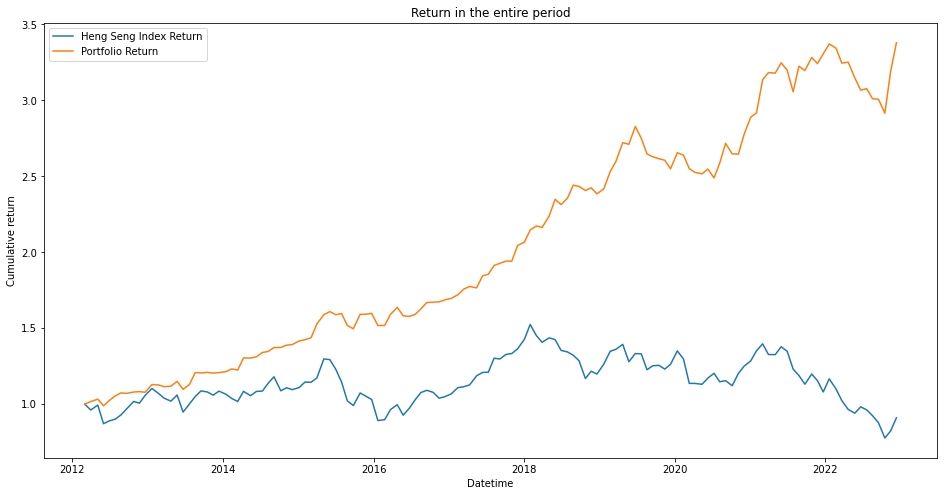

Test set startdate: 2012-03-01 00:00:00
Test set enddate: 2022-11-14 00:00:00
Annualized return: 0.31551451992416896
The sharpe ratio: 0.2507842700510052
The information ratio: 0.23574595383434702


In [59]:
split = int(len(pred_prob)*train_val_ratio)
plt.figure(figsize=(16,8))
plt.plot(true_price.index.to_list()[:split],Index_list[:split],label='Heng Seng Index Return')
plt.plot(true_price.index.to_list()[:split],ret_list[:split],label='Portfolio Return')
plt.title('Return in train period')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Cumulative return')
plt.show()
t = pd.to_datetime(pred_prob.index.to_list()[:split][-1])-pd.to_datetime(pred_prob.index.to_list()[:split][0])
t = t.days
print('Test set startdate:',pred_prob.index.to_list()[:split][0])
print('Test set enddate:',pred_prob.index.to_list()[:split][-1])
print('Annualized return:',(ret_list[:split][-1]/ret_list[:split][0])/t*365)
print('The sharpe ratio:',sharpe_ratio(ret_list[:split],20))
print('The information ratio:',info_ratio(ret_list[:split],Index_list[:split],20))




plt.figure(figsize=(16,8))
Index_test = Index_list[split:]-Index_list[split]
ret_test = ret_list[split:]-ret_list[split]
plt.plot(true_price.index.to_list()[split:],Index_test,label='Heng Seng Index Return')
plt.plot(true_price.index.to_list()[split:],ret_test,label='Portfolio Return')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Cumulative return')
plt.title('Return in test period')
plt.show()

print('Test set startdate:',pred_prob.index.to_list()[split:][0])
print('Test set enddate:',pred_prob.index.to_list()[split:][-1])
t = pd.to_datetime(pred_prob.index.to_list()[split:][-1])-pd.to_datetime(pred_prob.index.to_list()[split:][0])
t = t.days
print('Annualized return:',(ret_list[split:][-1]/ret_list[split:][0])/t*365)
print('The sharpe ratio:',sharpe_ratio(ret_list[split:],20))
print('The information ratio:',info_ratio(ret_list[split:],Index_list[split:],20))



plt.figure(figsize=(16,8))
plt.plot(true_price.index.to_list(),Index_list,label='Heng Seng Index Return')
plt.plot(true_price.index.to_list(),ret_list,label='Portfolio Return')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Cumulative return')
plt.title('Return in the entire period')
plt.show()
t = pd.to_datetime(pred_prob.index.to_list()[-1])-pd.to_datetime(pred_prob.index.to_list()[0])
t = t.days
print('Test set startdate:',pred_prob.index.to_list()[0])
print('Test set enddate:',pred_prob.index.to_list()[-1])
print('Annualized return:',(ret_list[-1]/ret_list[0])/t*365)
print('The sharpe ratio:',sharpe_ratio(ret_list,20))
print('The information ratio:',info_ratio(ret_list,Index_list,20))



In [165]:
from captum.attr import IntegratedGradients, GuidedGradCam
k = 34214#99449#79843#7876
x = torch.tensor(train_x[k].copy()).float()
y = train_y[k]
x = x.reshape(-1,1,64,60)
x.requires_grad = True
baseline = torch.zeros_like(x)
print(y,new_net(x.to('cuda')))

[1 0] tensor([[0.5522, 0.4478]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


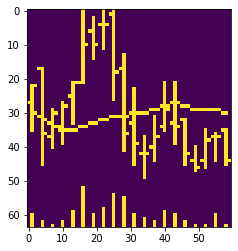

In [166]:
plt.imshow(x[0,0].detach().cpu().numpy())

In [85]:
cam_layer_1 = GuidedGradCam(new_net, new_net.layer1)
attributions_layer_1 = cam_layer_1.attribute(x.cuda(), target=0)
cam_layer_2 = GuidedGradCam(new_net, new_net.layer2)
attributions_layer_2 = cam_layer_2.attribute(x.cuda(), target=0)
cam_layer_3 = GuidedGradCam(new_net, new_net.layer3)
attributions_layer_3 = cam_layer_3.attribute(x.cuda(), target=0)

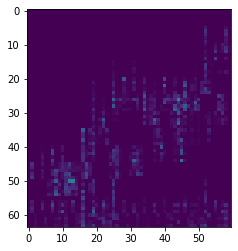

In [86]:
plt.imshow(abs(attributions_layer_1.detach().cpu().numpy()[0,0]), vmax=1e-8)

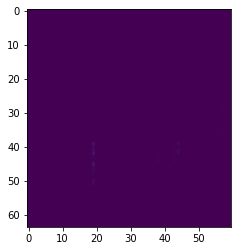

In [87]:
plt.imshow(abs(attributions_layer_2.detach().cpu().numpy()[0,0]), vmax=1e-7)

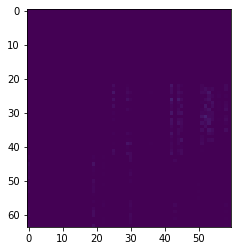

In [88]:
plt.imshow(abs(attributions_layer_3.detach().cpu().numpy()[0,0]), vmax=1e-7)

In [167]:
ig = IntegratedGradients(new_net)
attributions, delta = ig.attribute(x.cuda(), baseline.cuda(), target=0, return_convergence_delta=True)

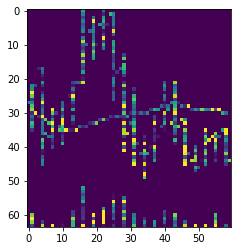

In [168]:
plt.imshow(abs(attributions.detach().cpu().numpy()[0,0]),vmin=0,vmax=0.02)